# The Problem

Notebook Code: [![License: MIT](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0) Notebook Prose: [![License: CC BY 4.0](https://img.shields.io/badge/License-CC_BY_4.0-lightgrey.svg)](https://creativecommons.org/licenses/by/4.0/)

---

**H**igh-**P**erformance **L**iquid **C**hromatography (HPLC) is an analytical 
technique which allows for the quantitative characterization of the chemical
components of a mixture. While many of the technical details of HPLC are now
automated, the programmatic cleaning and processing of the resulting data can be
cumbersome and often requires extensive manual labor. 


Consider a scenario where you have an environmental sample that contains several 
different chemical species. Through the principle of [chromatographic separation](https://en.wikipedia.org/wiki/Chromatography), you use an HPLC instrument to decompose the sample into its
constituents by measuring the time it takes for each analyte to pass through 
the column. This measurement is typically performed by measuring a change in index of refraction 
or absorption at a specific wavelength. The resulting data, the detected signal as a function of time, is a chromatogram which may look something like this

Text(0, 0.5, 'signal [mV]')

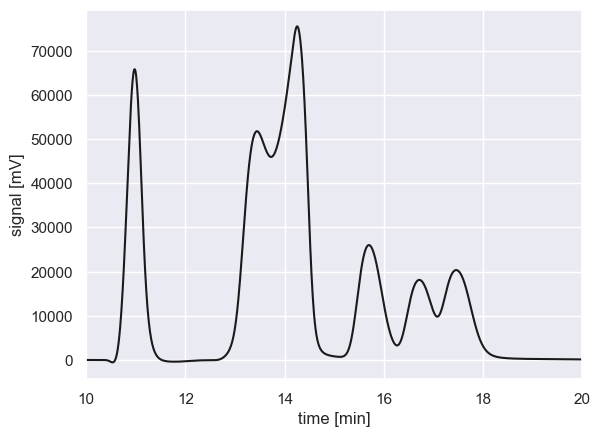

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load the measurement 
data = pd.read_csv('./data/sample_chromatogram.txt')

# Plot the chromatogram
fig, ax = plt.subplots(1,1)
ax.plot(data['time_min'], data['intensity_mV'], 'k-')
ax.set_xlim(10, 20)
ax.set_xlabel('time [min]')
ax.set_ylabel('signal [mV]')

By eye, it looks like there may be six individual compounds in the sample. Some 
are isolated (e.g., the peak at 11 min) while others are severely overlapping
(e.g. the peaks from 13-15 min). This indicates that some of the compounds 
have similar elution times through the column with this particular mobile phase.

While its easy for us to see these peaks, how do we quantify them? How can 
we tease apart peaks that are overlapping? This is easier to say than to do. 
There are several tools available to do this that are open source (such as [HappyTools](https://github.com/Tarskin/HappyTools)) 
or proprietary (such as [Chromeleon](https://www.thermofisher.com/order/catalog/product/CHROMELEON7)). However,
in many cases peaks are quantified simply but integrating only the non-overlapping 
regions. 

Hplc-Py, however, fits mixtures of [skewnormal distributions](https://en.wikipedia.org/wiki/Skew_normal_distribution) to regions of the  chromatogram that contain either singular or highly overlapping peaks, allowing one to go from the chromatogram above to a decomposed mixture in a few lines 
of Python code.

Deconvolving mixture: 100%|██████████| 2/2 [00:13<00:00,  6.65s/it]


-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

A+, Success:  Peak Window 1 (t: 10.558 - 11.758) R-Score = 0.9984
A+, Success:  Peak Window 2 (t: 12.117 - 19.817) R-Score = 0.9952

Signal Reconstruction of Interpeak Windows
                  
C-, Needs Review:  Interpeak Window 1 (t: 10.000 - 10.550) R-Score = 0.3902 & Fano Ratio = 0.0024
Interpeak window 1 is not well reconstructed by mixture, but has a small Fano factor  
compared to peak region(s). This is likely acceptable, but visually check this region.

C-, Needs Review:  Interpeak Window 2 (t: 11.767 - 12.108) R-Score = 10^-3 & Fano Ratio = 0.0012
Interpeak window 2 is not well reconstructed by mixture, but has a small Fano factor  
compared to peak region(s). This is likely acceptable, but visually check this region.

C-, Needs Review:  Interpeak Window 3 (t: 19.825 - 20.000) R-Score = 10^-1 & Fano Ratio = 0.0000
Interpeak window 3 is not well reconstructed by mixture

,retention_time,scale,skew,amplitude,area,signal_maximum,peak_id
0,10.90,0.158768,0.691961,23380.386403,2.805646e+06,66064.361454,1
0,13.17,0.594721,3.905471,43163.880069,5.179666e+06,50341.309040,2
0,14.45,0.349615,-2.995742,34698.966317,4.163876e+06,65264.935100,3
0,15.53,0.313999,1.621135,15061.414798,1.807370e+06,26771.462516,4
0,16.52,0.347275,1.990202,10936.991812,1.312439e+06,18651.422318,5
0,17.29,0.348001,1.703715,12525.286105,1.503034e+06,20381.897950,6


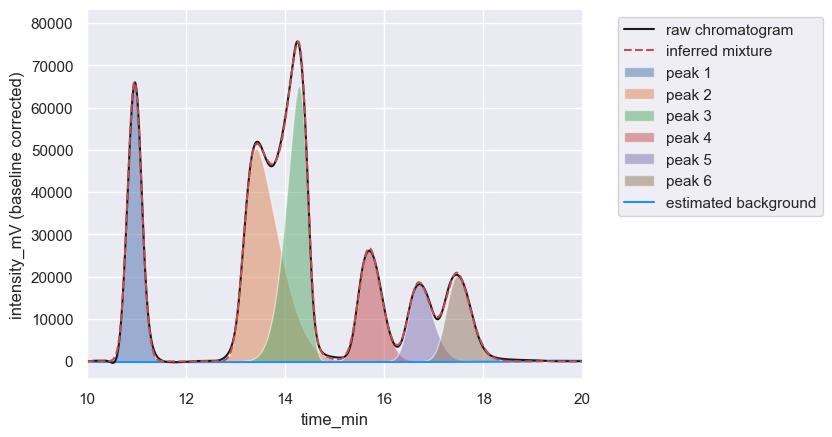

In [2]:
# Show the power of hplc-py
from hplc.quant import Chromatogram
chrom = Chromatogram(data, cols={'time':'time_min', 'signal':'intensity_mV'})
chrom.crop([10, 20])
peaks = chrom.fit_peaks()
scores = chrom.assess_fit()

# Display the results
chrom.show(time_range=[10, 20])
peaks

## How It Works
The peak detection and quantification algorithm in `hplc-py` involves the following 
steps.

1. Estimation of signal background using [Statistical Nonlinear Iterative Peak (SNIP) estimation](https://doi.org/10.1366/000370208783412762). 
2. Automatic detection of peak maxima given threshold criteria (such as peak prominence) and clipping of the signal into peak windows.
3. For a window with $N$ peaks, a mixture of $N$ skew-normal disttributions are inferred using the measured peak properties (such as location, maximum value, and width at half-maximum) are used as initial guesses. This inference is performed through an optimization by minimization procedure. This inference is repeated for each window in the 
chromatogram. 
4. The estimated mixture of all compounds is computed given the parameter estimates of each distribution and the agreement between the observed data and the inferred peak mixture is determined via a reconstruction score.

The following notebooks will go through each step of the algorithm in detail.

---

<small> © Griffin Chure, 2024. This notebook and the code within are released under a 
[Creative-Commons CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) and 
[GPLv3](https://www.gnu.org/licenses/gpl-3.0) license, respectively.</small>
